In [23]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [24]:
ndvi_img_dir = "/home/dat/Workspace/Thesis/lettuce_detector/data/raw/2017-10-27_NDVI/lettuce"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Lettuce/2017-10-27.csv"

### Distribution of NDVI values

In [25]:
lettuce_ndvi = {}
for fname in os.listdir(ndvi_img_dir):
    img = np.asarray(Image.open(os.path.join(ndvi_img_dir, fname)).convert("L"))
    ndvi = img / 256
    lettuce_ndvi[fname.split(".")[0]] = np.average(ndvi)

In [26]:
ndvi_values = list(lettuce_ndvi.values())

print("Average: %.4f" % np.average(ndvi_values))
print("Std Dev: %.4f" % np.std(ndvi_values))

Average: 0.7880
Std Dev: 0.0406


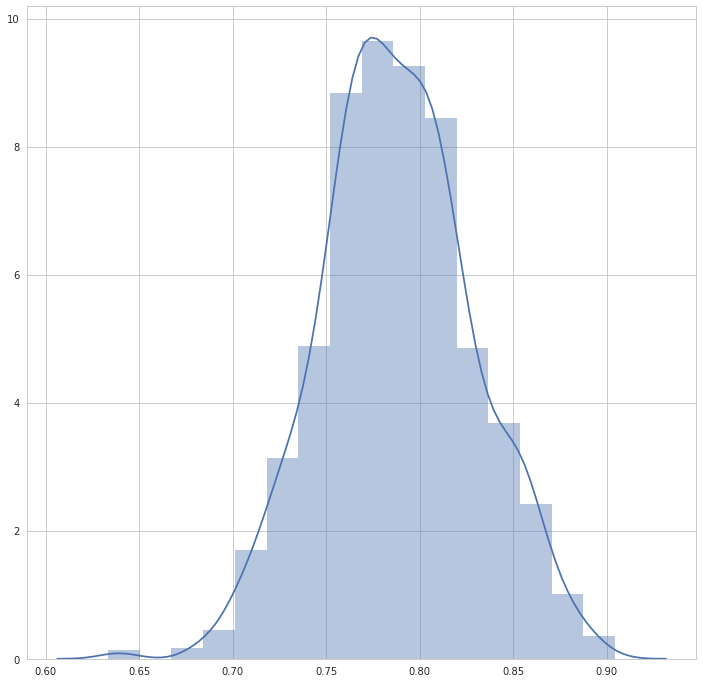

In [27]:
sns.distplot(ndvi_values, bins=16)

In [28]:
nitrogen_ndvi = {}
irrigation_ndvi = {}
for treatment in [100, 50, 25, 0]:
    nitrogen_ndvi[treatment] = []
    irrigation_ndvi[treatment] = []
    for k, v in lettuce_ndvi.items():
        if "N{}".format(treatment) in k:
            nitrogen_ndvi[treatment].append(v)
        if "IR{}".format(treatment) in k:
            irrigation_ndvi[treatment].append(v)

In [29]:
nitrogen_avg = {k:np.average(values) for k, values in nitrogen_ndvi.items()}
nitrogen_stddev = {k:np.std(values) for k, values in nitrogen_ndvi.items()}

print(nitrogen_avg)
print(nitrogen_stddev)

{100: 0.79567280105725702, 50: 0.77936646251208785, 25: 0.77862219642298602, 0: 0.7981957718864221}
{100: 0.043949371845878361, 50: 0.031862234375543273, 25: 0.03383267024465933, 0: 0.046601906282988333}


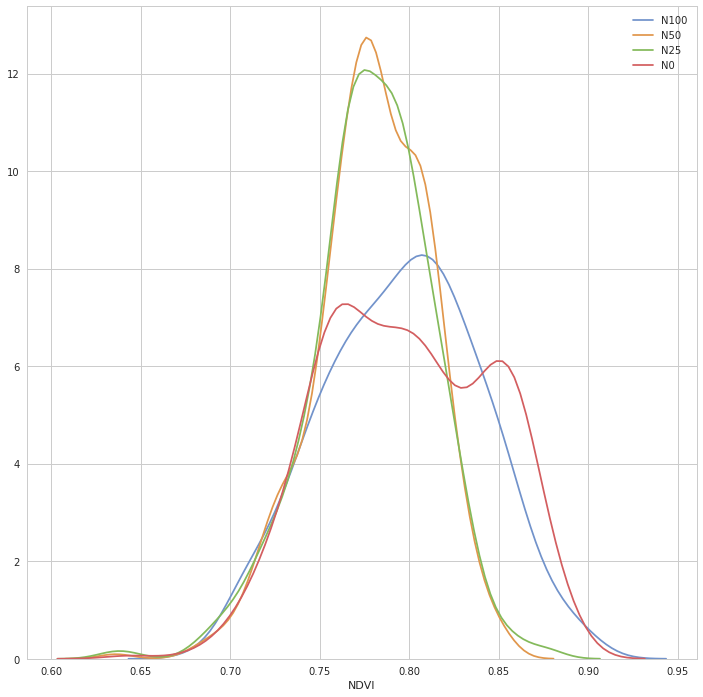

In [30]:
sns.distplot(nitrogen_ndvi[100], bins=16, hist=False, color="#7293CB", label="N100")
sns.distplot(nitrogen_ndvi[50],  bins=16, hist=False, color="#E1974C", label="N50")
sns.distplot(nitrogen_ndvi[25],  bins=16, hist=False, color="#84BA5B", label="N25")
sns.distplot(nitrogen_ndvi[0],   bins=16, hist=False, color="#D35E60", label="N0", axlabel="NDVI")

In [31]:
irrigation_avg = {k:np.average(values) for k, values in irrigation_ndvi.items()}
irrigation_stddev = {k:np.std(values) for k, values in irrigation_ndvi.items()}

print(irrigation_avg)
print(irrigation_stddev)

{100: 0.80103793846677873, 50: 0.78936253793421307, 25: 0.79276971044493549, 0: 0.76887744034025762}
{100: 0.039606668129293351, 50: 0.035869442862202068, 25: 0.039884533302097132, 0: 0.040155838721198892}


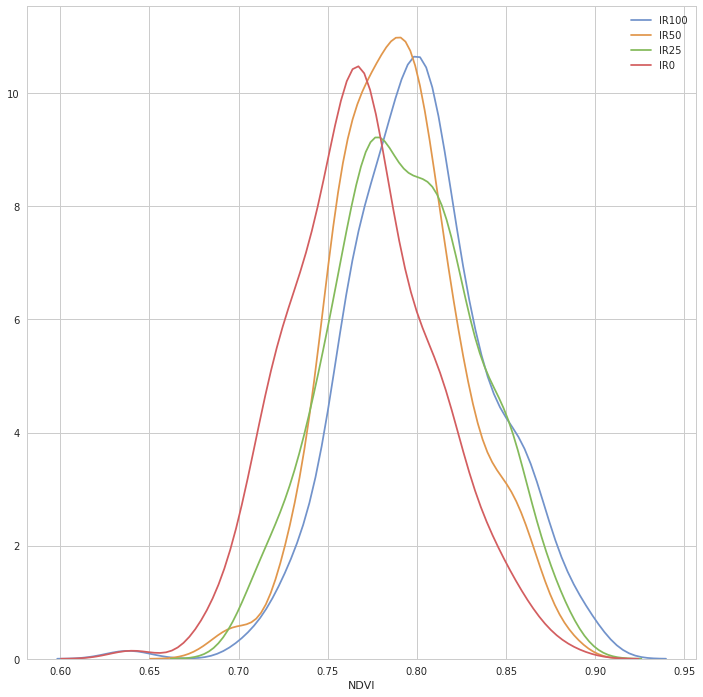

In [32]:
sns.distplot(irrigation_ndvi[100], bins=16, hist=False, color="#7293CB", label="IR100")
sns.distplot(irrigation_ndvi[50],  bins=16, hist=False, color="#E1974C", label="IR50")
sns.distplot(irrigation_ndvi[25],  bins=16, hist=False, color="#84BA5B", label="IR25")
sns.distplot(irrigation_ndvi[0],   bins=16, hist=False, color="#D35E60", label="IR0", axlabel="NDVI")

### Analyze ground data

In [33]:
df = pd.read_csv(csv_file)
df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
0,0,0,1,104,48.9,0.805878,-4.80,6,7
1,0,0,1,113,44.4,0.815393,NaN,6,7
2,0,0,2,104,48.8,0.839747,-4.24,4,6
3,0,0,2,113,53.5,0.819832,NaN,4,6
4,0,0,3,104,51.9,0.812323,-4.82,7,6


In [34]:
pre_df = {
    "Nitrogen": [],
    "Irrigation": [],
    "Replication": [],
    "Plant Number": [],
    "uav_ndvi": [],
}
for k, v in lettuce_ndvi.items():
    nitrogen = int(re.search("N(.*)IR.*", k).group(1))
    irrigation = int(re.search(".*IR(.*)Rep.*", k).group(1))
    replication = int(re.search(".*Rep(.*)_", k).group(1))
    number = int(re.search(".*_(.*)", k).group(1))
    
    if number == 104 or number == 113:
        pre_df["Nitrogen"].append(nitrogen)
        pre_df["Irrigation"].append(irrigation)
        pre_df["Replication"].append(replication)
        pre_df["Plant Number"].append(number)
        pre_df["uav_ndvi"].append(v)

ndvi_df = pd.DataFrame(data=pre_df)

In [35]:
merged_df = pd.merge(df, ndvi_df, on=["Nitrogen", "Irrigation", "Replication", "Plant Number"])
merged_df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,uav_ndvi
0,0,0,1,104,48.9,0.805878,-4.80,6,7,0.745226
1,0,0,1,113,44.4,0.815393,NaN,6,7,0.778239
2,0,0,2,104,48.8,0.839747,-4.24,4,6,0.733744
3,0,0,2,113,53.5,0.819832,NaN,4,6,0.772461
4,0,0,3,104,51.9,0.812323,-4.82,7,6,0.838335


In [36]:
print("UAV NDVI & Chlorophyll:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["Chlorophyll"])[0])
print("UAV NDVI & NDVI:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["NDVI"])[0])
print("UAV NDVI & Height:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["Average Height"])[0])
print("UAV NDVI & Leaf Count:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["Average Leaf Count"])[0])
print("UAV NDVI & WP:", stats.pearsonr(merged_df.dropna()["uav_ndvi"], merged_df.dropna()["WP"])[0])

UAV NDVI & Chlorophyll: 0.156329166505
UAV NDVI & NDVI: 0.0672011325308
UAV NDVI & Height: 0.213202013835
UAV NDVI & Leaf Count: 0.0134507638953
UAV NDVI & WP: 0.33524960417


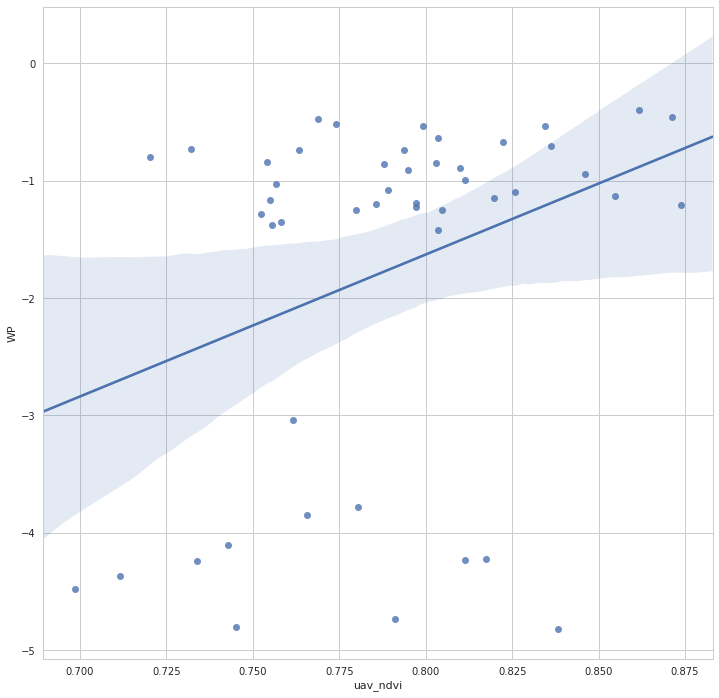

In [37]:
sns.regplot(x=merged_df["uav_ndvi"], y=merged_df["WP"])